In [1]:
import scanpy as sc
data_dir = '../../dataset/Human_Great_Apes_filtered.h5ad'
adata = sc.read_h5ad(data_dir)

In [2]:
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 753825891 stored elements and shape (156285, 17413)>
  Coords	Values
  (0, 12862)	0.5665589570999146
  (0, 3064)	0.5665589570999146
  (0, 13278)	3.3999741077423096
  (0, 813)	2.833569049835205
  (0, 13496)	4.101833820343018
  (0, 5722)	2.5798444747924805
  (0, 15309)	7.879579067230225
  (0, 2014)	0.5665589570999146
  (0, 7585)	5.2227888107299805
  (0, 6840)	5.497739791870117
  (0, 12721)	3.967062473297119
  (0, 15364)	1.8461450338363647
  (0, 8240)	1.5708974599838257
  (0, 11878)	2.2390189170837402
  (0, 8802)	5.875441551208496
  (0, 4476)	4.394822597503662
  (0, 10574)	0.5665589570999146
  (0, 16860)	6.168292999267578
  (0, 2182)	5.933631896972656
  (0, 8212)	2.520345449447632
  (0, 7982)	5.331713676452637
  (0, 2798)	5.730631351470947
  (0, 6747)	0.9259976744651794
  (0, 2034)	6.668968677520752
  (0, 9759)	3.3205926418304443
  :	:
  (156284, 2496)	3.841771125793457
  (156284, 12674)	3.841771125793457
  (156284, 3173)	4.524

In [3]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPBarlowTwins
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/BarlowTwins.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPBarlowTwins(
        gene_dim=19331,  # 根据你的数据调整
        batch_size=128,  # 根据你的需要调整
        units_encoder=units_encoder,
        CHECKPOINT_PATH=ckpt_path
    )


estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")
GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [4]:
# 加载 checkpoint
checkpoint = torch.load(ckpt_path)
estim.model.inner_model.load_state_dict({k.replace('backbone.', ''): v for k, v in checkpoint.items() if 'backbone' in k})


<All keys matched successfully>

In [5]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

18

In [6]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [7]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [8]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

feature
OPN1MW    OPN1MW
KY            KY
COL6A6    COL6A6
EVI2A      EVI2A
UBE2D4    UBE2D4
           ...  
SDF2        SDF2
OSR1        OSR1
SOWAHB    SOWAHB
CHCHD3    CHCHD3
ACTR8      ACTR8
Name: gene_name, Length: 17413, dtype: category
Categories (29813, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYG11AP1', 'ZYG11B', 'ZZEF1', 'ZZZ3']

In [9]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)


In [10]:
existing_genes = adata.var['gene_name']
existing_genes

feature
OPN1MW    OPN1MW
KY            KY
COL6A6    COL6A6
EVI2A      EVI2A
UBE2D4    UBE2D4
           ...  
SDF2        SDF2
OSR1        OSR1
SOWAHB    SOWAHB
CHCHD3    CHCHD3
ACTR8      ACTR8
Name: gene_name, Length: 17413, dtype: category
Categories (29813, object): ['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYG11AP1', 'ZYG11B', 'ZZEF1', 'ZZZ3']

In [11]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 17413
匹配的基因列表: {'neto1', 'nup155', 'pdf', 'ppfibp2', 'c16orf96', 'mtf1', 'rimbp3c', 'coasy', 'selenbp1', 'csf3', 'hs3st5', 'acad10', 'lrat', 'wdr12', 'coro6', 'frem1', 'unc5d', 'ca6', 'sdcbp2', 'atp2c2', 'gns', 'b3gnt4', 'zfpm1', 'pacsin1', 'suclg1', 'ccr10', 'slc7a6os', 'vps50', 'sh3gl1', 'adam19', 'pou3f1', 'tuba1c', 'ttc8', 'cdc25a', 'ube2h', 'eno1', 'slc35f6', 'clybl', 'rpgr', 'nkx2-5', 'or1f1', 'crybb3', 'large2', 'prex2', 'ppfia3', 'mrto4', 'aspa', 'vdac1', 'ift52', 'irak2', 'thg1l', 'rsbn1', 'or52n2', 'ptges', 'med1', 'cdk18', 'foxo1', 'ccnd1', 'macf1', 'etfbkmt', 'ssna1', 'foxd3', 'dennd1a', 'gucy1a2', 'tubb4a', 'tmem252', 'alpk3', 'zeb2', 'zc3h6', 'wdr13', 'sgip1', 'pycr1', 'jph2', 'msrb2', 'cacng4', 'rnf168', 'dennd2d', 'nipa2', 'glb1', 'znf443', 'h2bc18', 'aqp6', 'a4galt', 'slitrk3', 'marcks', 'or5d3p', 'atp6v0b', 'tomm40l', 'ppcs', 'or56b4', 'cd163', 'tspan8', 'arl11', 'asb13', 'csnk1g3', 'spred2', 'agap1', 'adamts19', 'dtnb', 'relt', 'veph1', 'tet2', 'cadm1', 'lin

set()

In [12]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [13]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 1918
仅在 all_genes 中存在的基因: {'krtap4-4', 'spdye16', 'tmem225b', 'mapt', 'fam71c', 'ccnb1ip1', 'pqbp1', 'kiaa0100', 'defb107b', 'tollip', 'h2bs1', 'kiaa1109', 'klhl33', 'gfer', 'abcf1', 'hmox2', 'f8', 'ccdc197', 'guca1anb', 'c17orf64', 'pdcd6-ahrr', 'oosp2', 'tbc1d3f', 'arhgap11b', 'magea12', 'tex51', 'tas2r46', 'trim75p', 'ppp1r3b', 'myt1', 'deaf1', 'tspy9p', 'med18', 'fam246a', 'atg16l1', 'prxl2b', 'sapcd1', 'lilrb2', 'cpne6', 'znf852', 'f2', 'c20orf27', 'krt33b', 'grk1', 'pklr', 'mtrnr2l1', 'ccdc120', 'taf11l10', 'hla-dpb1', 'defb107a', 'znf251', 'epop', 'krtap4-7', 'usp17l7', 'med16', 'sntg2', 'spaca9', 'dlx1', 'or4m2b', 'prb4', 'tpbg', 'tnk1', 'znf705d', 'serf1a', 'smim43', 'taf9', 'lilra1', 'dxo', 'defb136', 'padi3', 'scarf1', 'tprkb', 'trim10', 'prr4', 'rwdd2b', 'fam95c', 'sinhcaf', 'spata48', 'hla-dqb2', 'tas2r20', 'dcaf15', 'or2a42', 'cnot10', 'ifnl2', 'c1orf158', 'heatr9', 'eif4a3', 'pcdhb12', 'mrps36', 'ppial4a', 'cwc25', 'ech1', 'rtl10', 'mdc1', 'sod2', 

In [14]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [15]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.20, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [16]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.inner_model.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.inner_model.parameters())[-5:]:
    param.requires_grad = True

In [17]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.inner_model(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.inner_model(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [19]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.14327794929018492, Validation Loss: 0.051569012164765476
Validation loss improved to 0.051569012164765476, resetting patience.


Epoch 2, Train Loss: 0.053273017545857074, Validation Loss: 0.05977384622912018
No improvement in validation loss. Patience counter: 1/20


Epoch 3, Train Loss: 0.04387440999822455, Validation Loss: 0.04012517838225681
Validation loss improved to 0.04012517838225681, resetting patience.


Epoch 4, Train Loss: 0.04113188351086489, Validation Loss: 0.03043449598231486
Validation loss improved to 0.03043449598231486, resetting patience.


Epoch 5, Train Loss: 0.038537298135016634, Validation Loss: 0.038678792445939414
No improvement in validation loss. Patience counter: 1/20


Epoch 6, Train Loss: 0.034542983704364746, Validation Loss: 0.034838468570034115
No improvement in validation loss. Patience counter: 2/20


Epoch 7, Train Loss: 0.035357734884070624, Validation Loss: 0.026469333242263873
Validation loss improved to 0.026469333242263873, resetting patience.


Epoch 8, Train Loss: 0.032964162600936944, Validation Loss: 0.03772993885664916
No improvement in validation loss. Patience counter: 1/20


Epoch 9, Train Loss: 0.03184544381605827, Validation Loss: 0.03218910596333444
No improvement in validation loss. Patience counter: 2/20


Epoch 10, Train Loss: 0.032148830092030525, Validation Loss: 0.02737909679168037
No improvement in validation loss. Patience counter: 3/20


Epoch 11, Train Loss: 0.03176144302897613, Validation Loss: 0.032369116058915244
No improvement in validation loss. Patience counter: 4/20


Epoch 12, Train Loss: 0.030277760656509868, Validation Loss: 0.026618095758199997
No improvement in validation loss. Patience counter: 5/20


Epoch 13, Train Loss: 0.029253293308753415, Validation Loss: 0.030187577127041867
No improvement in validation loss. Patience counter: 6/20


Epoch 14, Train Loss: 0.031086158705081177, Validation Loss: 0.02663226707135232
No improvement in validation loss. Patience counter: 7/20


Epoch 15, Train Loss: 0.029146016159445544, Validation Loss: 0.06508187331468324
No improvement in validation loss. Patience counter: 8/20


Epoch 16, Train Loss: 0.028448245470478147, Validation Loss: 0.026355547718323616
Validation loss improved to 0.026355547718323616, resetting patience.


Epoch 17, Train Loss: 0.03093245639984298, Validation Loss: 0.029461281481484067
No improvement in validation loss. Patience counter: 1/20


Epoch 18, Train Loss: 0.02680145908292576, Validation Loss: 0.0334115799763525
No improvement in validation loss. Patience counter: 2/20


Epoch 19, Train Loss: 0.028083833072037215, Validation Loss: 0.040355398371454555
No improvement in validation loss. Patience counter: 3/20


Epoch 20, Train Loss: 0.026451982601290367, Validation Loss: 0.029981923416347186
No improvement in validation loss. Patience counter: 4/20


Epoch 21, Train Loss: 0.027871776690708516, Validation Loss: 0.028897300710407445
No improvement in validation loss. Patience counter: 5/20


Epoch 22, Train Loss: 0.028386167686217875, Validation Loss: 0.024240457278923416
Validation loss improved to 0.024240457278923416, resetting patience.


Epoch 23, Train Loss: 0.02603844735863692, Validation Loss: 0.029170882382088016
No improvement in validation loss. Patience counter: 1/20


Epoch 24, Train Loss: 0.025899340253447832, Validation Loss: 0.028298105739475207
No improvement in validation loss. Patience counter: 2/20


Epoch 25, Train Loss: 0.02713048782489945, Validation Loss: 0.03393115332274108
No improvement in validation loss. Patience counter: 3/20


Epoch 26, Train Loss: 0.02598468091969866, Validation Loss: 0.024889871797272554
No improvement in validation loss. Patience counter: 4/20


Epoch 27, Train Loss: 0.025932078598045565, Validation Loss: 0.02858467043082857
No improvement in validation loss. Patience counter: 5/20


Epoch 28, Train Loss: 0.02624242004242314, Validation Loss: 0.0324254206612193
No improvement in validation loss. Patience counter: 6/20


Epoch 29, Train Loss: 0.02419383835616378, Validation Loss: 0.026685034164835756
No improvement in validation loss. Patience counter: 7/20


Epoch 30, Train Loss: 0.025049769221998797, Validation Loss: 0.028268096928142618
No improvement in validation loss. Patience counter: 8/20


Epoch 31, Train Loss: 0.0263975408597815, Validation Loss: 0.02510844641175045
No improvement in validation loss. Patience counter: 9/20


Epoch 32, Train Loss: 0.0234032866512781, Validation Loss: 0.038305138865229196
No improvement in validation loss. Patience counter: 10/20


Epoch 33, Train Loss: 0.02419715397467133, Validation Loss: 0.02669242759239955
No improvement in validation loss. Patience counter: 11/20


Epoch 34, Train Loss: 0.028433736634795207, Validation Loss: 0.029407489476535393
No improvement in validation loss. Patience counter: 12/20


Epoch 35, Train Loss: 0.023395192269016676, Validation Loss: 0.027213471637544583
No improvement in validation loss. Patience counter: 13/20


Epoch 36, Train Loss: 0.023946053447029686, Validation Loss: 0.04608409643667389
No improvement in validation loss. Patience counter: 14/20


Epoch 37, Train Loss: 0.024617404663831437, Validation Loss: 0.025416235205223212
No improvement in validation loss. Patience counter: 15/20


Epoch 38, Train Loss: 0.024532205340710416, Validation Loss: 0.03376472532554359
No improvement in validation loss. Patience counter: 16/20


Epoch 39, Train Loss: 0.023620523287672335, Validation Loss: 0.024849061563858115
No improvement in validation loss. Patience counter: 17/20


Epoch 40, Train Loss: 0.02485807223829484, Validation Loss: 0.024857474334552238
No improvement in validation loss. Patience counter: 18/20


Epoch 41, Train Loss: 0.023528493958101946, Validation Loss: 0.03328949563319282
No improvement in validation loss. Patience counter: 19/20


Epoch 42, Train Loss: 0.02458831509703098, Validation Loss: 0.02324443957602073
Validation loss improved to 0.02324443957602073, resetting patience.


Epoch 43, Train Loss: 0.023363330207004672, Validation Loss: 0.024616113591140933
No improvement in validation loss. Patience counter: 1/20


Epoch 44, Train Loss: 0.024079211781644433, Validation Loss: 0.03267381030600518
No improvement in validation loss. Patience counter: 2/20


Epoch 45, Train Loss: 0.023194299191088792, Validation Loss: 0.0341940249321146
No improvement in validation loss. Patience counter: 3/20


Epoch 46, Train Loss: 0.02356343391345208, Validation Loss: 0.031395492373195916
No improvement in validation loss. Patience counter: 4/20


Epoch 47, Train Loss: 0.023514676513372683, Validation Loss: 0.02353723549227021
No improvement in validation loss. Patience counter: 5/20


Epoch 48, Train Loss: 0.024558484334165756, Validation Loss: 0.023221686939775412
No improvement in validation loss. Patience counter: 6/20


Epoch 49, Train Loss: 0.02374603823707204, Validation Loss: 0.02378251667048934
No improvement in validation loss. Patience counter: 7/20


Epoch 50, Train Loss: 0.023230591511269993, Validation Loss: 0.024377678786119333
No improvement in validation loss. Patience counter: 8/20


Epoch 51, Train Loss: 0.022914263617101548, Validation Loss: 0.024658863765083024
No improvement in validation loss. Patience counter: 9/20


Epoch 52, Train Loss: 0.023275660071514055, Validation Loss: 0.028977548367609934
No improvement in validation loss. Patience counter: 10/20


Epoch 53, Train Loss: 0.02338848328614121, Validation Loss: 0.022105916267099353
Validation loss improved to 0.022105916267099353, resetting patience.


Epoch 54, Train Loss: 0.024407411013707, Validation Loss: 0.02639592428197514
No improvement in validation loss. Patience counter: 1/20


Epoch 55, Train Loss: 0.023754294830584697, Validation Loss: 0.025137776689489886
No improvement in validation loss. Patience counter: 2/20


Epoch 56, Train Loss: 0.0220464968227681, Validation Loss: 0.03109871632590586
No improvement in validation loss. Patience counter: 3/20


Epoch 57, Train Loss: 0.02319272670688077, Validation Loss: 0.023313380291267317
No improvement in validation loss. Patience counter: 4/20


Epoch 58, Train Loss: 0.023349231559159692, Validation Loss: 0.027373962895944716
No improvement in validation loss. Patience counter: 5/20


Epoch 59, Train Loss: 0.022308152069289704, Validation Loss: 0.020902376554013058
Validation loss improved to 0.020902376554013058, resetting patience.


Epoch 60, Train Loss: 0.025534478852982437, Validation Loss: 0.0335640091130662
No improvement in validation loss. Patience counter: 1/20


Epoch 61, Train Loss: 0.02232179411234001, Validation Loss: 0.025174501680826047
No improvement in validation loss. Patience counter: 2/20


Epoch 62, Train Loss: 0.023092736452589215, Validation Loss: 0.028281641596861716
No improvement in validation loss. Patience counter: 3/20


Epoch 63, Train Loss: 0.02284665781046749, Validation Loss: 0.02265108061873601
No improvement in validation loss. Patience counter: 4/20


Epoch 64, Train Loss: 0.022073150437751196, Validation Loss: 0.03359574448716428
No improvement in validation loss. Patience counter: 5/20


Epoch 65, Train Loss: 0.024163883469035113, Validation Loss: 0.02289042999416742
No improvement in validation loss. Patience counter: 6/20


Epoch 66, Train Loss: 0.022034649173615167, Validation Loss: 0.02233791979105801
No improvement in validation loss. Patience counter: 7/20


Epoch 67, Train Loss: 0.02325961477231834, Validation Loss: 0.0284743884017653
No improvement in validation loss. Patience counter: 8/20


Epoch 68, Train Loss: 0.022493800700189213, Validation Loss: 0.04067506377528213
No improvement in validation loss. Patience counter: 9/20


Epoch 69, Train Loss: 0.02237950949720806, Validation Loss: 0.03159333777861023
No improvement in validation loss. Patience counter: 10/20


Epoch 70, Train Loss: 0.02271856419180836, Validation Loss: 0.05161799303284485
No improvement in validation loss. Patience counter: 11/20


Epoch 71, Train Loss: 0.02337472796248587, Validation Loss: 0.02668817820210409
No improvement in validation loss. Patience counter: 12/20


Epoch 72, Train Loss: 0.021220309662379803, Validation Loss: 0.027100407196760025
No improvement in validation loss. Patience counter: 13/20


Epoch 73, Train Loss: 0.02172735664217846, Validation Loss: 0.023628885281861436
No improvement in validation loss. Patience counter: 14/20


Epoch 74, Train Loss: 0.02339515913218148, Validation Loss: 0.02559518993912949
No improvement in validation loss. Patience counter: 15/20


Epoch 75, Train Loss: 0.022058649713619476, Validation Loss: 0.024918247851048958
No improvement in validation loss. Patience counter: 16/20


Epoch 76, Train Loss: 0.022100560256052258, Validation Loss: 0.029152692085588162
No improvement in validation loss. Patience counter: 17/20


Epoch 77, Train Loss: 0.02219015959693398, Validation Loss: 0.023206108648862158
No improvement in validation loss. Patience counter: 18/20


Epoch 78, Train Loss: 0.022020708568890338, Validation Loss: 0.036964921724070246
No improvement in validation loss. Patience counter: 19/20


Epoch 79, Train Loss: 0.023232498686153336, Validation Loss: 0.022701752515110585
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 79.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


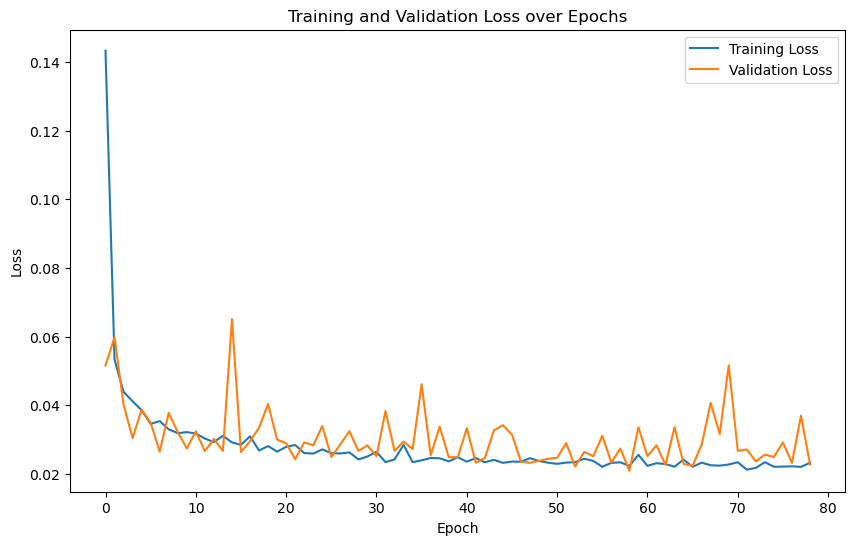

In [20]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [21]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.inner_model(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.inner_model(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [22]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.994241289951051
Weighted F1 Score: 0.9942271353532072
Macro F1 Score: 0.9825275683693983
Random Guess Accuracy: 0.32775393340845166
                                                                precision    recall  f1-score   support

     L2/3-6 intratelencephalic projecting glutamatergic neuron       1.00      1.00      1.00     17236
L5 extratelencephalic projecting glutamatergic cortical neuron       1.00      0.99      0.99        87
                             L6b glutamatergic cortical neuron       0.98      0.97      0.97       702
                            VIP GABAergic cortical interneuron       0.99      0.99      0.99      2022
                              astrocyte of the cerebral cortex       1.00      1.00      1.00       639
                caudal ganglionic eminence derived interneuron       0.92      0.88      0.90       162
                              cerebral cortex endothelial cell       1.00      1.00      1.00        27
      

In [23]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "Human_Great_Apes_barlow_twins_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['Human_Great_Apes'],
    'method': [re.search(r'Human_Great_Apes_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.143	0.052	59	0.021	0.983	0.994	0.994
